
# CIFAR-10 Unlearning Report — Delta Aggregation by `unlearn_epochs`

This notebook reads a results CSV (e.g. `CIFAR10_BTI_DBF_U_results.csv`) and, for each distinct value of `unlearn_epochs`, reports:
- **Average change in benign accuracy:** `benign_accuracy - orig_benign_accuracy`
- **Average change in attack success rate:** `attack_success_rate - orig_attack_success_rate`

It also saves the aggregated table to `unlearn_epoch_deltas.csv` alongside the notebook.


In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Display options for pandas
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', None)


In [2]:

# === Configuration ===
# Set your CSV path here. Example: 'CIFAR10_BTI_DBF_U_results.csv'
CSV_PATH = 'CIFAR10_BTI_DBF_U_results.csv'
OUTPUT_SUMMARY = 'unlearn_epoch_deltas.csv'

# If your file isn't comma-separated, we will let pandas infer the delimiter.
# If inference fails, set sep explicitly, e.g., sep='\t' for TSV.


In [3]:

# Try to read with automatic delimiter inference (python engine supports sep=None)
try:
    df = pd.read_csv(CSV_PATH, sep=None, engine='python')
except Exception as e:
    raise RuntimeError(f"Failed to read CSV at {CSV_PATH}. "
                       f"If your file is tab-separated, set sep='\t' explicitly. Original error: {e}")

# Show basic info to confirm columns
display(df.head())
print("\nColumns:", list(df.columns))


,experiment_id,model_type,variant_name,mask_epochs,unet_epochs,unet_tau,unet_lr,unet_p,unet_lambda_tau,train_method,mask_loss,gen_total_loss,unlearn_epochs,unlearn_lr,feature_w,model_name,split_mode,unet_delta,orig_benign_accuracy,orig_attack_success_rate,benign_accuracy,attack_success_rate,overall_accuracy,clean_samples,triggered_samples,alt_rounds
0,e8d3be0a-4de0-4e0c-9a1c-18b190dcd253,CIFAR10,paper-branch-final,20,30,10.0,0.01,2,5000,branch,-2.792940,-0.721655,6,0.001,1.0,Model_1197.pth,final,True,91.7875,90.7,80.2,17.8,0.7990,1000,1000,2
1,d2f41298-a01d-4c62-8bde-7f27cd52651c,CIFAR10,paper-branch-final,20,30,4.0,0.01,2,5000,branch,-2.410026,-0.246165,6,0.001,1.0,Model_1197.pth,final,True,91.7875,90.7,79.7,18.9,0.7945,1000,1000,2
2,8a66cc58-f973-45d8-b74f-b5f305fa6749,CIFAR10,paper-branch-final,20,30,2.0,0.01,2,5000,branch,-2.135667,0.023433,6,0.001,1.0,Model_1197.pth,final,True,91.7875,90.7,80.5,18.8,0.7965,1000,1000,2
3,76a497af-aaba-47f6-8434-e0ef214dc478,CIFAR10,paper-branch-final,20,30,1.0,0.01,2,5000,branch,-1.448749,0.025517,6,0.001,1.0,Model_1197.pth,final,True,91.7875,90.7,80.6,18.0,0.7890,1000,1000,2
4,357056ce-56bc-48c2-b91e-2dc99a9cf23d,CIFAR10,paper-branch-final,20,30,0.4,0.01,2,5000,branch,-2.386725,0.949538,6,0.001,1.0,Model_1197.pth,final,True,91.7875,90.7,78.3,15.4,0.7745,1000,1000,2



Columns: ['experiment_id', 'model_type', 'variant_name', 'mask_epochs', 'unet_epochs', 'unet_tau', 'unet_lr', 'unet_p', 'unet_lambda_tau', 'train_method', 'mask_loss', 'gen_total_loss', 'unlearn_epochs', 'unlearn_lr', 'feature_w', 'model_name', 'split_mode', 'unet_delta', 'orig_benign_accuracy', 'orig_attack_success_rate', 'benign_accuracy', 'attack_success_rate', 'overall_accuracy', 'clean_samples', 'triggered_samples', 'alt_rounds']


In [4]:

required_cols = [
    'unlearn_epochs',
    'orig_benign_accuracy', 'benign_accuracy',
    'orig_attack_success_rate', 'attack_success_rate',
    'alt_rounds', 'unet_tau',
]

missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")


In [5]:

df = df.copy()
df['delta_benign_accuracy'] = df['benign_accuracy'] - df['orig_benign_accuracy']
df['delta_attack_success_rate'] = df['attack_success_rate'] - df['orig_attack_success_rate']

display(df[['unlearn_epochs', 'orig_benign_accuracy', 'benign_accuracy',
            'orig_attack_success_rate', 'attack_success_rate',
            'delta_benign_accuracy', 'delta_attack_success_rate', 'alt_rounds']].head())


,unlearn_epochs,orig_benign_accuracy,benign_accuracy,orig_attack_success_rate,attack_success_rate,delta_benign_accuracy,delta_attack_success_rate,alt_rounds
0,6,91.7875,80.2,90.7,17.8,-11.5875,-72.9,2
1,6,91.7875,79.7,90.7,18.9,-12.0875,-71.8,2
2,6,91.7875,80.5,90.7,18.8,-11.2875,-71.9,2
3,6,91.7875,80.6,90.7,18.0,-11.1875,-72.7,2
4,6,91.7875,78.3,90.7,15.4,-13.4875,-75.3,2


In [6]:

summary = (
    df.groupby('unet_tau', as_index=True)
      [['delta_benign_accuracy', 'delta_attack_success_rate']]
      .mean()
      .sort_index()
      .rename(columns={
          'delta_benign_accuracy': 'avg_delta_benign_accuracy',
          'delta_attack_success_rate': 'avg_delta_attack_success_rate'
      })
)

display(summary)

# Save summary
pd.DataFrame(summary).to_csv(OUTPUT_SUMMARY)
print(f"Saved summary CSV to: {Path(OUTPUT_SUMMARY).resolve()}")


,avg_delta_benign_accuracy,avg_delta_attack_success_rate
unet_tau,,
0.2,-10.951529,-78.136348
0.3,-8.931529,-78.536348
0.4,-10.231529,-79.056348
1.0,-9.611529,-78.036348
2.0,-9.131529,-78.296348
4.0,-11.351529,-77.516348
10.0,-9.171529,-78.576348


Saved summary CSV to: /home/tyler/Desktop/ResearchProject/unlearn_epoch_deltas.csv


In [7]:

counts = df.groupby('unet_tau').size().rename('n_rows')
display(counts.to_frame())


,n_rows
unet_tau,
0.2,5
0.3,5
0.4,5
1.0,5
2.0,5
4.0,5
10.0,5


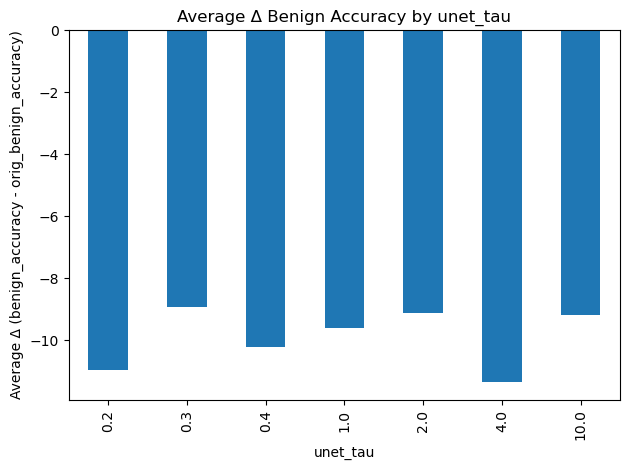

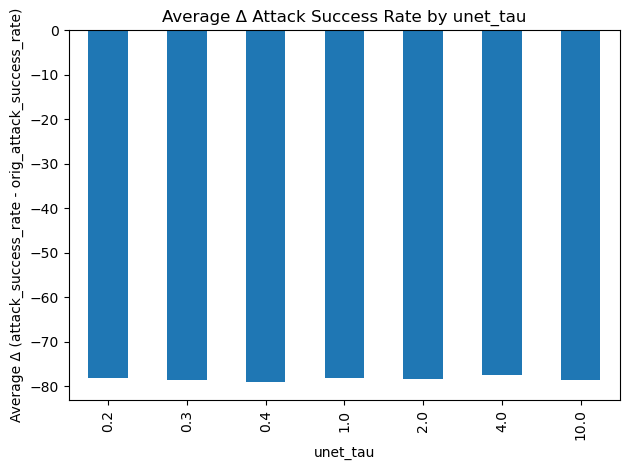

In [8]:

# Bar chart: avg delta benign accuracy
plt.figure()
summary['avg_delta_benign_accuracy'].plot(kind='bar')
plt.title('Average Δ Benign Accuracy by unet_tau')
plt.xlabel('unet_tau')
plt.ylabel('Average Δ (benign_accuracy - orig_benign_accuracy)')
plt.tight_layout()
plt.show()

# Bar chart: avg delta attack success rate
plt.figure()
summary['avg_delta_attack_success_rate'].plot(kind='bar')
plt.title('Average Δ Attack Success Rate by unet_tau')
plt.xlabel('unet_tau')
plt.ylabel('Average Δ (attack_success_rate - orig_attack_success_rate)')
plt.tight_layout()
plt.show()
